In [47]:
import fastf1
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import LineString
import numpy as np

In [48]:

session = fastf1.get_session(2023, 'Monza', 'Q')
session.load(telemetry=True, laps=True, weather=False)

core           INFO 	Loading data for Italian Grand Prix - Qualifying [v3.3.5]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['55', '1', '16', '63', '11', '23', '81', '44', '4', '14', '22', '40', '27', '77', '2', '24', '10', '31', '20', '18']


In [263]:
laps = session.laps
lap_55_1 = laps.pick_driver('55').pick_lap(2).get_telemetry()
f1_api_coords = list(zip(lap_55_1["Y"],lap_55_1["X"]))

In [264]:
lap_55_1

,Date,SessionTime,DriverAhead,DistanceToDriverAhead,Time,RPM,Speed,nGear,Throttle,Brake,DRS,Source,Distance,RelativeDistance,Status,X,Y,Z
2,2023-09-02 14:05:31.832,0 days 00:20:31.721000,,612.977222,0 days 00:00:00,11232,315,8,100,False,8,interpolation,0.009046,0.000002,OnTrack,-1383,-796,1870
3,2023-09-02 14:05:31.910,0 days 00:20:31.799000,,612.977222,0 days 00:00:00.078000,11244,316,8,100,False,8,pos,6.873083,0.001188,OnTrack,-1378,-729,1871
4,2023-09-02 14:05:32.011,0 days 00:20:31.900000,,612.977222,0 days 00:00:00.179000,11267,317,8,100,False,8,car,15.773611,0.002726,OnTrack,-1370,-640,1871
5,2023-09-02 14:05:32.090,0 days 00:20:31.979000,,612.977222,0 days 00:00:00.258000,11292,317,8,100,False,8,pos,22.745243,0.003930,OnTrack,-1365,-571,1872
6,2023-09-02 14:05:32.172,0 days 00:20:32.061000,16,612.977222,0 days 00:00:00.340000,11317,318,8,100,False,8,car,29.995278,0.005183,OnTrack,-1358,-497,1872
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
623,2023-09-02 14:06:53.831,0 days 00:21:53.720000,44,22.322361,0 days 00:01:21.999000,11236,314,8,100,False,8,pos,5739.177619,0.991760,OnTrack,-1404,-1047,1870
624,2023-09-02 14:06:53.851,0 days 00:21:53.740000,2,23.332778,0 days 00:01:22.019000,11283,316,8,100,False,8,car,5740.936667,0.992064,OnTrack,-1402,-1030,1870
625,2023-09-02 14:06:54.031,0 days 00:21:53.920000,2,20.377222,0 days 00:01:22.199000,11286,316,8,100,False,8,pos,5756.772682,0.994801,OnTrack,-1392,-894,1871
626,2023-09-02 14:06:54.131,0 days 00:21:54.020000,2,17.421667,0 days 00:01:22.299000,11290,317,8,100,False,8,car,5765.592222,0.996325,OnTrack,-1385,-809,1871


There are two different systems, EPSG and UTM, look at this post https://docs.qgis.org/2.18/en/docs/gentle_gis_introduction/coordinate_reference_systems.html \
First we use UTM to get the zone from this image: https://docs.qgis.org/2.18/en/_images/utm_zones.png \
Then we convert the UTM zone into EPSG. We convert to EPSG since thats what pandas like. There is probably another reason aswell, find out

In [265]:
from pyproj import CRS

# or dictionary
crs = CRS.from_dict({'proj': 'utm', 'zone': 32, 'south': False})

print(crs.to_authority())  # ('EPSG', '32736')

('EPSG', '32632')


In [266]:
import geopandas as gpd
import folium

# Load the GeoDataFrame
monza_track = gpd.read_file("bacinger f1-circuits master circuits/it-1922.geojson")
centroid = monza_track.geometry.centroid.iloc[0]

# Ensure the GeoDataFrame is in WGS84 (lat/lon)
#monza_track = monza_track.to_crs(epsg=4326)

# Convert to a projected CRS suitable for buffering (e.g., UTM)
# Note: Choose the correct UTM zone for your specific data. Here, we assume zone 32N.
# This is something we add manually 
monza_track_projected = monza_track.to_crs(epsg=32632)

# Process the geometry to add width by buffering (buffer distance in meters)
width_in_meters = 5  # Specify the width of the track. Adjust according to needs.
monza_track_buffered = monza_track_projected.copy(deep = True)
monza_track_buffered['geometry'] = monza_track_buffered.geometry.buffer(width_in_meters)

C:\Users\tjupp\AppData\Local\Temp\ipykernel_1312\798706167.py:6: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroid = monza_track.geometry.centroid.iloc[0]


In [267]:
monza_track.geometry.centroid

C:\Users\tjupp\AppData\Local\Temp\ipykernel_1312\3923669336.py:1: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  monza_track.geometry.centroid


0    POINT (9.28671 45.62347)
dtype: geometry

In [268]:
# Create a folium map centered at the centroid
m = folium.Map(location=[centroid.y, centroid.x], zoom_start=15)

# Add the GeoDataFrame to the map
folium.GeoJson(monza_track_buffered).add_to(m)

# Display the map
#m.save("monza_track_map.html")
m  # This line is optional and just to display the map inline, if your

In [269]:
from shapely.geometry import LineString
from shapely.affinity import translate

# Initial LineString and target centroid
original_line_string = LineString(f1_api_coords)
target_centroid_lon =  45.623470812745815
target_centroid_lat = 9.286713930962872

# Calculate the current centroid of the original LineString
current_centroid = original_line_string.centroid

# Calculate the shifts
shift_x = target_centroid_lon - current_centroid.x
shift_y = target_centroid_lat - current_centroid.y

# Apply translation to the entire geometry
shifted_line_string = translate(original_line_string, xoff=shift_x, yoff=shift_y)

In [270]:
shifted_line_string.centroid.x

45.62347081273493

In [271]:
shifted_line_string.centroid.y

9.286713930965226

In [272]:
monza_track.geometry.centroid

C:\Users\tjupp\AppData\Local\Temp\ipykernel_1312\3923669336.py:1: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  monza_track.geometry.centroid


0    POINT (9.28671 45.62347)
dtype: geometry

In [273]:
gdf = gpd.GeoDataFrame(index=[0], geometry=[shifted_line_string])

In [317]:
# Function to determine UTM zone from longitude
from pyproj import Proj, Transformer

def determine_utm_zone(longitude):
    return int((longitude + 180) / 6) + 1

# Define WGS84 as our coordinate reference system
proj_wgs84 = Proj(proj='latlong', datum='WGS84')

# Define UTM based on the origin's longitude
origin_lon, origin_lat =9.286713930962872,45.623470812745815
utm_zone = determine_utm_zone(origin_lon)
is_northern = origin_lat >= 0
proj_utm = Proj(proj='utm', zone=utm_zone, datum='WGS84', hemisphere='north' if is_northern else 'south')

# Set up a transformer between WGS84 and UTM
transformer_to_utm = Transformer.from_proj(proj_wgs84, proj_utm)
transformer_to_wgs84 = Transformer.from_proj(proj_utm, proj_wgs84)

# Function to convert relative coordinates to lat/lon
def relative_to_latlon(origin, relative_coords):
    lon_origin, lat_origin = origin
    utm_x_origin, utm_y_origin = transformer_to_utm.transform(lat_origin, lon_origin)
    
    latlon_coords = []
    for x_rel,y_rel in relative_coords:
        # Translate relative to absolute in UTM
        utm_x_coords = utm_x_origin + x_rel
        utm_y_coords = utm_y_origin + y_rel
        
        # Convert back to lon/lat
        lon,lat = transformer_to_wgs84.transform(utm_y_coords, utm_x_coords)
        latlon_coords.append((lon, lat))
    
    return latlon_coords

# Example origin point in longitude and latitude
origin = (9.286713930962872,45.623470812745815)

# Example LineString in relative coordinates (in meters)
relative_line = LineString(f1_api_coords)

# Translate relative LineString to lat/lon
relative_coords = relative_line.coords
translated_coords = relative_to_latlon(origin, relative_coords)

# Create a new LineString in longitude and latitude
translated_line = LineString(translated_coords)
list(translated_line.coords)

[(18.498731351521563, 43.04691009930305),
 (18.498884568574603, 43.047500075155014),
 (18.49910454919921, 43.04828239583922),
 (18.499260542145354, 43.0488901331702),
 (18.49944767562256, 43.04954024742198),
 (18.499648648275294, 43.050279173879765),
 (18.50029381233587, 43.052609375682096),
 (18.500949767980032, 43.05492967347451),
 (18.50112864575818, 43.055526494306186),
 (18.501608556672533, 43.05726772555803),
 (18.50173312451875, 43.05775213312515),
 (18.502170516749164, 43.05929898726342),
 (18.50238403323781, 43.06011783401323),
 (18.502684767368514, 43.06118129288743),
 (18.503000744296216, 43.062342443035114),
 (18.503105957383752, 43.062702510735534),
 (18.50371477842608, 43.064954769997854),
 (18.503831080755315, 43.065385885508206),
 (18.504363118973004, 43.067302683828544),
 (18.504814538386665, 43.06893832724962),
 (18.50492116531227, 43.06930727245577),
 (18.505151046036595, 43.07015173558174),
 (18.505350813316497, 43.070881758873725),
 (18.505692536416127, 43.07204974

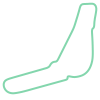

In [316]:
translated_line

In [300]:
translated_line.centroid.x

43.11190922011133

In [301]:
translated_line.centroid.y

18.564445565331127

In [226]:
centroid.x

9.286713930962872

In [227]:
centroid.y

45.623470812745815

In [ ]:
45.623470812745815  9.286713930962872


In [12]:
lap_55_1

,Date,SessionTime,DriverAhead,DistanceToDriverAhead,Time,RPM,Speed,nGear,Throttle,Brake,DRS,Source,Distance,RelativeDistance,Status,X,Y,Z
3,2023-09-02 14:03:48.251,0 days 00:18:48.140000,,194.836111,0 days 00:00:00.074000,6938,80,2,19,False,8,car,1.644444,0.000300,OnTrack,-925.026682,2361.235516,-1.369417e-43
5,2023-09-02 14:03:48.571,0 days 00:18:48.460000,16,194.836111,0 days 00:00:00.394000,6846,80,2,19,False,8,car,8.755556,0.001598,OnTrack,-922.578445,2432.253942,4.320352e-43
7,2023-09-02 14:03:48.811,0 days 00:18:48.700000,16,201.769444,0 days 00:00:00.634000,6975,80,2,22,False,8,car,14.088889,0.002571,OnTrack,-921.059064,2490.247295,-7.593702e-43
10,2023-09-02 14:03:49.171,0 days 00:18:49.060000,16,212.669444,0 days 00:00:00.994000,7050,82,2,22,False,8,car,22.288889,0.004068,OnTrack,-921.001934,2560.970811,-2.497971e-41
12,2023-09-02 14:03:49.331,0 days 00:18:49.220000,16,217.647222,0 days 00:00:01.154000,7075,82,2,21,False,8,car,25.933333,0.004733,OnTrack,-920.997597,2596.464659,4.395010e-40
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
752,2023-09-02 14:05:30.731,0 days 00:20:30.620000,16,607.788333,0 days 00:01:42.554000,10995,306,8,100,False,8,car,5367.490278,0.979669,OnTrack,-1450.887667,-1706.074547,1.867094e+03
754,2023-09-02 14:05:31.011,0 days 00:20:30.900000,16,610.121667,0 days 00:01:42.834000,11034,310,8,100,False,8,car,5391.601389,0.984070,OnTrack,-1434.361278,-1464.244576,1.868827e+03
756,2023-09-02 14:05:31.251,0 days 00:20:31.140000,16,612.188333,0 days 00:01:43.074000,11120,312,8,100,False,8,car,5412.401389,0.987867,OnTrack,-1421.531174,-1286.997963,1.868830e+03
759,2023-09-02 14:05:31.491,0 days 00:20:31.380000,16,614.121667,0 days 00:01:43.314000,11171,313,8,100,False,8,car,5433.268056,0.991675,OnTrack,-1406.935746,-1088.129165,1.870007e+03


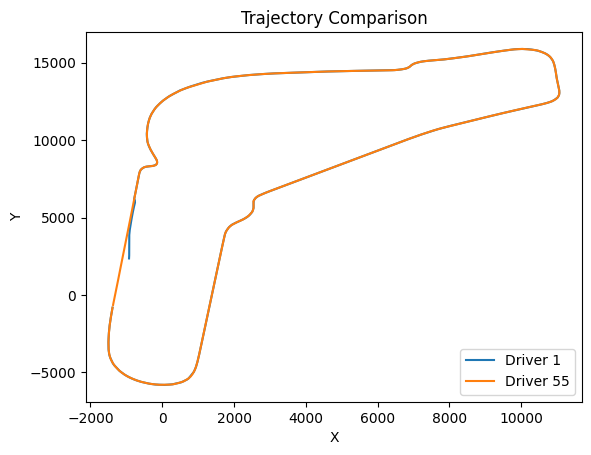

In [13]:
plt.plot(lap_55_1['X'], lap_55_1['Y'], label='Driver 1')
plt.plot(lap_55_2['X'], lap_55_2['Y'], label='Driver 55')

plt.xlabel('X')
plt.ylabel('Y')
plt.title('Trajectory Comparison')
plt.legend()  # Show legend with labels

plt.show()


In [ ]:
plt.plot(lap_55_1['X'][80:90], lap_55_1['Y'][80:90], label='Driver 55 Lap 1')
plt.plot(lap_55_2['X'][45:55], lap_55_2['Y'][45:55], label='Driver 55 Lap 2')

plt.xlabel('X')
plt.ylabel('Y')
plt.title('Trajectory Comparison')
plt.legend()  # Show legend with labels

plt.show()